<a href="https://colab.research.google.com/github/compi1234/pyspch/blob/master/test/spectrogram_test_ly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Spectrogram 

Comparing matplotlib with plotly

In [1]:
# You may need to install following packages
# !pip install plotly=4.12
# !pip install git+https://github.com/compi1234/pyspch.git
# !pip install pydub
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Choose which plot package to use; choices are "mpl" and "plotly"
_PLOT_PKG_ = "mpl"

### Do the imports and get your data ready

In [2]:
%matplotlib inline
import os,sys 
import numpy as np
import pandas as pd
from IPython.display import display, Audio, HTML, clear_output
import ipywidgets as widgets
#
import pyspch.spectrogram as specg
import pyspch.audio as audio
import pyspch.utils as spch

try: _PLOT_PKG_ 
except: _PLOT_PKG_ = 'mpl'
if _PLOT_PKG_ == "plotly": 
    import pyspch.display_ly as spch_disp
    import plotly 
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.io as pio
    print(plotly.__version__,"renderer: ",pio.renderers.default)   
else:                      
    import matplotlib.pyplot as plt
    import pyspch.display as spch_disp

# When using plotly, you may need to set a new default renderer
# as the automatic detection doesn't always work flawless and presets may have a big impact on
# memory usage
# e.g. > pio.renderers.default='jupyterlab'
# other options include 'notebook', 'plotly_mimetype'

In [3]:
# set basename and directories
dir='https://homes.esat.kuleuven.be/~spchlab/data/'
file = "timit/si1027" #@param {type:"string"}
basename = dir+file
wavfname = basename + ".wav"
wrdfname = basename + ".wrd"
phnfname = basename + ".phn"
phone_mapping = "timit/phones-61-48-39.txt" #@param {type:"string"}

# 1. read the waveform data
wavdata, sr = audio.load(wavfname)

# 2. compute spectrogram
f_shift = 0.01
spgdata = specg.spectrogram(wavdata,sample_rate=sr,f_shift=f_shift,n_mels=None)
(nparam,nfr) = spgdata.shape
spg_xaxis = (np.arange(nfr)+0.5)*f_shift
spg_yaxis = np.arange(nparam)*sr/(2.*(nparam-1))

# 3. get segmentations
segwrd = pd.read_csv(wrdfname,delim_whitespace=True,names=['t0','t1','seg'])
segphn61 = pd.read_csv(phnfname,delim_whitespace=True,names=['t0','t1','seg'])
# convert TIMIT61 to TIMIT39
# this routine is not great as it simply maps closures to silence instead to combining
phone_tbl = pd.read_csv(dir+phone_mapping,delim_whitespace=True,names=['T61','T48','T39'])
map61_48 = dict(zip(phone_tbl['T61'],phone_tbl['T48']))
segphn = segphn61.replace({"seg": map61_48})
# convert TIMIT sample based segmentations to time based segmentations
segphn['t0']=specg.indx2t(segphn['t0'],1./sr)
segphn['t1']=specg.indx2t(segphn['t1'],1./sr)
segwrd['t0']=specg.indx2t(segwrd['t0'],1./sr)
segwrd['t1']=specg.indx2t(segwrd['t1'],1./sr)

### 1. Spectrogram 

CPU times: user 109 ms, sys: 3.9 ms, total: 113 ms
Wall time: 111 ms


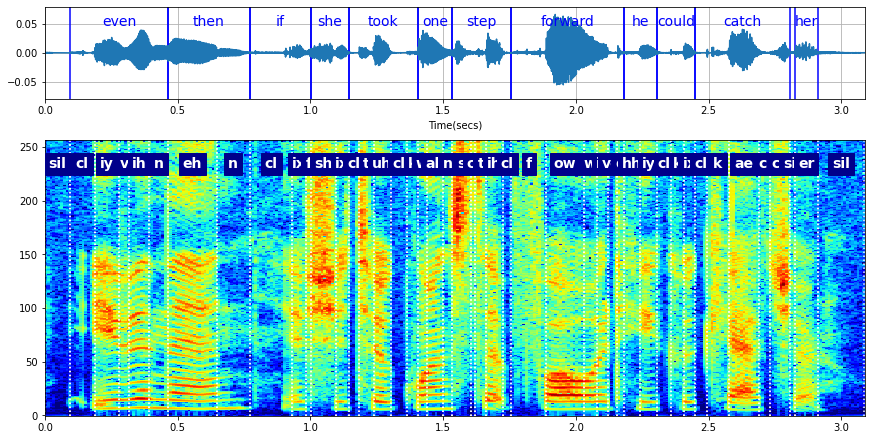

In [4]:
%%time
spch_disp.plot_spg(spgdata,wav=wavdata,sample_rate=sr,f_shift=f_shift,segwav=segwrd,segspg=segphn)

### 2. Interactive Spectrogram with Frame Sliders

In [5]:
def box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

class interactive_spectrogram(widgets.VBox):
    def __init__(self,spg,wavdata,f_shift=0.01,sample_rate=16000,dpi=100):
        super().__init__()
        (nparam,nfr)=spg.shape
        self.sample_rate = sample_rate
        self.f_shift = f_shift
        self.n_shift = int(f_shift*self.sample_rate)
        self.nfr = nfr
        self.frames = [0, self.nfr]
        self.times = [0., self.nfr*self.f_shift]
        self.spg = spg
        self.wavdata = wavdata
        self.autoplay = False
        self.dpi = dpi

        self.wg_range = widgets.FloatRangeSlider(value=self.times,min=self.times[0],max=self.times[1],step=self.f_shift,
                            description='Time Selection: ',continuous_update=False)
        self.wg_range.layout.width = str(10*dpi)+'px'
        self.wg_range.observe(self.range_observe,'value')
        self.wg_autoplay = widgets.Checkbox(value=self.autoplay,description='Play Selection',indent=False,button_style='warning')
        self.wg_autoplay.layout.width=str(2*dpi)+'px'
        self.wg_autoplay.observe(self.autoplay_observe, 'value')
        
        self.out = widgets.Output(layout=box_layout())
        self.wavout = widgets.Output()
        self.audio = widgets.Output()
        self.UI = widgets.VBox( [self.wg_range, self.wavout,
                                 widgets.HBox([self.wg_autoplay,self.audio ]) ],
                                 layout=box_layout())
        self.children = [ self.out , self.UI ]
        
        with self.wavout:
            wavfig = spch_disp.plot_waveform(self.wavdata,sample_rate=self.sample_rate,ylabel=None,xlabel=None,figsize=(10,1.5))
            display(wavfig)
        self.fig = spch_disp.plot_spg(self.spg,wav=self.wavdata,sample_rate=self.sample_rate,frames=self.frames,dpi=self.dpi)
        self.update(INIT=True)
        #self.figinit = self.fig
        
    def update(self,INIT=False):
        if not INIT:
            spch_disp.plot_spg(self.spg,fig=self.fig,wav=self.wavdata,sample_rate=self.sample_rate,
                       frames=self.frames)
        with self.out:
            #print("Should be displaying")
            clear_output(wait=True)
            #self.fig.show()
            display(self.fig)
        with self.audio:
            clear_output(wait=True)
            sample_range = [int(self.times[0]*self.sample_rate),int(self.times[1]*self.sample_rate)]
            display(Audio(data=self.wavdata[sample_range[0]:sample_range[1]],rate=self.sample_rate,autoplay=self.autoplay))
            
    def range_observe(self,change):
        self.times = change.new
        self.frames = [int(self.times[0]/self.f_shift), int(self.times[1]/self.f_shift)]
        self.update()
    def autoplay_observe(self,obj):
        self.autoplay = not self.autoplay
    

In [6]:
interactive_spectrogram(spgdata,wavdata,sample_rate=sr,dpi=72)

interactive_spectrogram(children=(Output(layout=Layout(border='solid 1px black', margin='0px 10px 10px 0px', p…